# UNW to $\Delta$ SWE

In [1]:
# import libraries
import os  # for chdir, getcwd, path.basename, path.exists
import hvplot.xarray
import pandas as pd # for DatetimeIndex 
import rioxarray
import xarray
import numpy as np #for log10, mean, percentile, power
import rasterio as rio
from rasterio.plot import show # plotting raster data
from rasterio.plot import show_hist #histograms of raster data

import glob # for listing files in tiff conversion function
import matplotlib.pyplot as plt # for add_subplot, axis, figure, imshow, legend, plot, set_axis_off, set_data,
                                # set_title, set_xlabel, set_ylabel, set_ylim, subplots, title, twinx

## Pull in Interferogram for phase data

In [2]:
# Change to tmp directory and download staged tutorial data
os.chdir('/tmp')

!aws s3 cp --no-progress s3://snowex-data/tutorial-data/sar/uavsar/ .  --recursive --exclude "*" --include "*tiff"

download: s3://snowex-data/tutorial-data/sar/uavsar/grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.hgt.grd.tiff to ./grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.hgt.grd.tiff
download: s3://snowex-data/tutorial-data/sar/uavsar/grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.amp1.grd.tiff to ./grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.amp1.grd.tiff
download: s3://snowex-data/tutorial-data/sar/uavsar/grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.cor.grd.tiff to ./grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.cor.grd.tiff
download: s3://snowex-data/tutorial-data/sar/uavsar/grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.amp2.grd.tiff to ./grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.amp2.grd.tiff
download: s3://snowex-data/tutorial-data/sar/uavsar/grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.int.grd.tiff to ./grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.int.grd.tiff
download: s3://snowex-data/tutorial-data/sar/uavsar

In [3]:
for unw_tiff_file in glob.glob("*unw.grd.tiff"):
    print(unw_tiff_file)

grmesa_27416_20003-028_20005-007_0011d_s01_L090HH_01.unw.grd.tiff


In [4]:
unw_rast = rio.open(unw_tiff_file)
meta_data1 = unw_rast.profile
print(meta_data1)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 7014, 'height': 4768, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(5.556e-05, 0.0, -108.30355248000001,
       0.0, -5.556e-05, 39.19030164), 'tiled': False, 'interleave': 'band'}


## Import Local Incidence Angle Raster

Processed (see scripts/incidence.ipynb) and stored locally for now (.inc files cannot currently be accessed from the ASF Vertex API, must be manually downloaded from the JPL site)

In [5]:
data_folder = '/tmp/grmesa_27416_21021_005_210322_L090_CX_01' # if doesn't exist, run scripts/incidence.ipynb first
inc_tiff_file = os.path.join(data_folder, os.path.basename(data_folder) + '.inc.tiff')

In [6]:
inc_rast = rio.open(inc_tiff_file)
meta_data2 = inc_rast.profile
print(meta_data2)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 8949, 'height': 4163, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(5.556e-05, 0.0, -108.37516932000001,
       0.0, -5.556e-05, 39.17963412), 'tiled': False, 'interleave': 'band'}


## Project to Same Grid

In [7]:
# from reproject_match() documentation
def print_raster(raster):
    print(
        f"shape: {raster.rio.shape}\n"
        f"resolution: {raster.rio.resolution()}\n"
        f"bounds: {raster.rio.bounds()}\n"
        f"sum: {raster.sum().item()}\n"
        f"CRS: {raster.rio.crs}\n"
    )

In [8]:
xds_unw = xarray.open_rasterio(unw_tiff_file)
xds_inc = xarray.open_rasterio(inc_tiff_file)
xds_unw = xds_unw.where(xds_unw!=0)
xds_inc = xds_inc.where(xds_inc!=-10000)

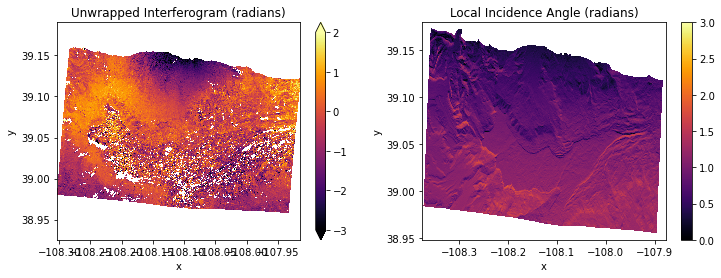

In [9]:
fig, axes = plt.subplots(ncols=2, figsize=(12,4))
xds_unw.plot(ax=axes[0],vmin=-3,vmax=2,cmap='inferno')
axes[0].set_title('Unwrapped Interferogram (radians)')
xds_inc.plot(ax=axes[1],vmin=0,vmax=3,cmap='inferno')
axes[1].set_title('Local Incidence Angle (radians)')
plt.draw()

In [10]:
print("Original Raster:\n----------------\n")
print_raster(xds_inc)
print("Raster to Match:\n----------------\n")
print_raster(xds_unw)

Original Raster:
----------------

shape: (4163, 8949)
resolution: (5.556e-05, -5.556e-05)
bounds: (-108.37516932000001, 38.94833784, -107.87796288000001, 39.17963412)
sum: 25668968.0
CRS: EPSG:4326

Raster to Match:
----------------

shape: (4768, 7014)
resolution: (5.556e-05, -5.556e-05)
bounds: (-108.30355248000001, 38.92539156, -107.91385464000001, 39.19030164)
sum: -6537910.0
CRS: EPSG:4326



In [11]:
xds_inc_repr_match = xds_inc.rio.reproject_match(xds_unw)

In [12]:
print("Reprojected Raster:\n----------------\n")
print_raster(xds_inc_repr_match)
print("Raster to Match:\n----------------\n")
print_raster(xds_unw)

Reprojected Raster:
----------------

shape: (4768, 7014)
resolution: (5.556000000000055e-05, -5.5559999999998526e-05)
bounds: (-108.30355248000001, 38.92539156, -107.91385464000001, 39.19030164)
sum: 21077480.0
CRS: EPSG:4326

Raster to Match:
----------------

shape: (4768, 7014)
resolution: (5.556e-05, -5.556e-05)
bounds: (-108.30355248000001, 38.92539156, -107.91385464000001, 39.19030164)
sum: -6537910.0
CRS: EPSG:4326



In [13]:
xds_inc_repr_match = xds_inc_repr_match.assign_coords({
    "x": xds_unw.x,
    "y": xds_unw.y,
})

## Phase to $\Delta$ SWE
$$
  \Delta SWE = \frac{\Delta \Phi \lambda_i}{2 \pi (1.59 + \theta_i^{5/2})}
$$ 

In [14]:
wavelength = 0.2379 # m

In [15]:
xds_delta_swe = (xds_unw*wavelength)/(2*np.pi*(1.59+xds_inc_repr_match**(5/2)))

Text(0.5, 1.0, 'Change in SWE (meters)')

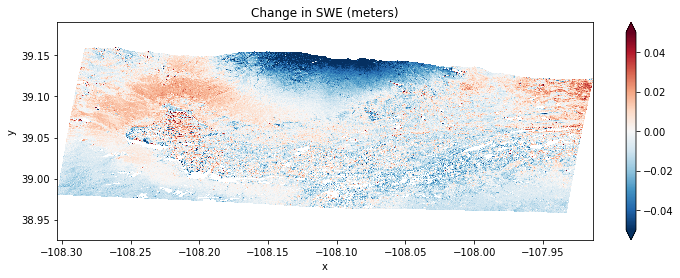

In [16]:
fig, axes = plt.subplots(figsize=(12,4))
xds_delta_swe.plot(ax=axes,vmin=-0.05,vmax=0.05,cmap='RdBu_r')
axes.set_title('Change in SWE (meters)')